## 0. Loading the libraries and data

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score, roc_auc_score, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import GaussianNB

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint, rv_discrete, rv_continuous
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.base import TransformerMixin

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer as wnl
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install gensim

In [3]:
from gensim.models import Word2Vec, FastText
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [4]:
train_url = 'https://raw.githubusercontent.com/Dmitrovich-Ivan/datasets/refs/heads/main/disaster_train.csv'
test_url = 'https://raw.githubusercontent.com/Dmitrovich-Ivan/datasets/refs/heads/main/disaster_test.csv'
sample_url = 'https://raw.githubusercontent.com/Dmitrovich-Ivan/datasets/refs/heads/main/disaster_sample_submission.csv'

train_df = pd.read_csv(train_url, index_col='id')
test_df = pd.read_csv(test_url, index_col='id')
sample_sub = pd.read_csv(sample_url, index_col='id')

## 1. Exploratory data analysis

In [5]:
train_df.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


- There are missing values in keyword and location columns
- The target class is slightly imbalanced

In [7]:
train_df['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


In [8]:
print('Unique keywords count:', train_df['keyword'].nunique())
print('Unique locations count:', train_df['location'].nunique())

Unique keywords count: 221
Unique locations count: 3341


- By the distribution of the target class for tweets with and without hashtags it is visible that tweets that contain hashtags are slighlty more likely to be about a real disaster
- Additionally, tweets without links that start with http are also more likely to be "True"

In [9]:
print(train_df[train_df['text'].str.contains('#')]['target'].value_counts(normalize=True))
print(train_df[~train_df['text'].str.contains('#')]['target'].value_counts(normalize=True))

target
0    0.503123
1    0.496877
Name: proportion, dtype: float64
target
0    0.590567
1    0.409433
Name: proportion, dtype: float64


In [10]:
print(train_df[train_df['text'].str.contains('http')]['target'].value_counts(normalize=True))
print(train_df[~train_df['text'].str.contains('http')]['target'].value_counts(normalize=True))

target
1    0.546965
0    0.453035
Name: proportion, dtype: float64
target
0    0.698243
1    0.301757
Name: proportion, dtype: float64


- Top 5 and bottom 5 keywords by their "likelihood" of indicating a real disaster tweet are displayed below. It is obvious that this feature might be very useful for predicting real/fake disaster tweet

In [11]:
train_df.groupby(["keyword"])['target'].agg(["mean", "count"]).sort_values(by="count", ascending=False).head(5)

,mean,count
keyword,,
fatalities,0.577778,45
deluge,0.142857,42
armageddon,0.119048,42
sinking,0.195122,41
damage,0.463415,41


In [12]:
train_df.groupby(["keyword"])['target'].agg(["mean", "count"]).sort_values(by="mean", ascending=False).head(5)

,mean,count
keyword,,
debris,1.000000,37
wreckage,1.000000,39
derailment,1.000000,39
outbreak,0.975000,40
oil%20spill,0.973684,38


In [13]:
train_df.groupby(["keyword"])['target'].agg(["mean", "count"]).sort_values(by="mean", ascending=False).tail(5)

,mean,count
keyword,,
body%20bag,0.030303,33
blazing,0.029412,34
ruin,0.027027,37
body%20bags,0.024390,41
aftershock,0.000000,34


- Below are displayed some of the locations, their count and a mean target value for each group

In [14]:
train_df.groupby(["location"])['target'].agg(["mean", "count"]).sort_values(by=["count", "mean"], ascending=False)

,mean,count
location,,
USA,0.644231,104
New York,0.225352,71
United States,0.540000,50
London,0.355556,45
Canada,0.448276,29
...,...,...
"ÌøåÀå_T: 40.736324,-73.990062",0.000000,1
å_: ?? ÌÑ ? : ?,0.000000,1
å_å_Los Mina Cityã¢,0.000000,1


## 2. Data preprocessing and feature engineering

- the corresponding functions are defined below

In [16]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text_nltk(text):
    return ' '.join([lemmatizer.lemmatize(w).lower() for w in w_tokenizer.tokenize(text)])

def lemmatize_text_spcy(text):
    return ' '.join([token.lemma_.lower() for token in nlp(text)])

In [17]:
def preprocess_data(df):
  data = df.copy()

  data['haslink'] = data['text'].str.contains('http').astype('int')
  data['hastag'] = data['text'].str.contains('#').astype('int')

  data['text'] = data['text'].replace(r'(http\S+) | (www\S+)|(@\S+) | (\&lt;|\&gt;|\&amp;) | (\x89\w+)', ' ', regex=True)

  data['text_nltk'] = data['text'].apply(lemmatize_text_nltk)
  data['text_spcy'] = data['text'].apply(lemmatize_text_spcy)

  data['text_nltk'] = data['text_nltk'].replace(r'(\W+)', ' ', regex=True)
  data['text_spcy'] = data['text_spcy'].replace(r'(\W+)', ' ', regex=True)

  data['token_nltk'] = data['text_nltk'].map(lambda x: [w for w in w_tokenizer.tokenize(x)])
  data['token_spcy'] = data['text_spcy'].map(lambda x: [token for token in nlp(x)])

  return data

In [18]:
def get_embeddings(model, train, test, token_feature, target):

  model.build_vocab(train[token_feature])
  model.train(train[token_feature], total_examples=model.corpus_count, epochs=model.epochs)

  X_train = np.array([np.mean([model.wv[w] for w in words if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for words in train[token_feature]])
  y_train = train[target].values.ravel()

  X_test = np.array([np.mean([model.wv[w] for w in words if w in model.wv] or [np.zeros(model.vector_size)], axis=0) for words in test[token_feature]])

  return X_train, y_train, X_test

In [19]:
def get_train_val(data, drop_cols, target, test_size=0.2):
  train, val = train_test_split(data, test_size=test_size, random_state=0, shuffle=True, stratify=train_df[target])

  X_train = train.drop(columns=drop_cols + target)
  y_train = train[target].values.ravel()

  X_val = val.drop(columns=drop_cols + target)
  y_val = val[target].values.ravel()

  return X_train, y_train, X_val, y_val

In [39]:
def visualize_tsne(data, target, n_components=2):
  tsne = TSNE(n_components=2, random_state=0)
  tsne_result = tsne.fit_transform(data)

  plt.figure(figsize=(8,6))
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=target, alpha=0.5)
  plt.show()

  return tsne_result

In [32]:
def feat_importances(features, coefs, k=10):
  feat_importance = pd.DataFrame({'feature': features,
                                  'feature_importance': np.abs(coefs),
                                  'coef_value': coefs}).sort_values('feature_importance', ascending=False)

  print(feat_importance[:k].to_markdown())

In [22]:
data = preprocess_data(train_df)
test_data = preprocess_data(test_df)

In [25]:
stop_words = list(stopwords.words('english'))

In [26]:
nltk_vocab = set()
spcy_vocab = set()

for text in data['text_nltk'].values:
  for word in text.split():
    nltk_vocab.add(word)

for text in data['text_spcy'].values:
  for word in text.split():
    spcy_vocab.add(word)

In [27]:
print(len(nltk_vocab))
print(len(spcy_vocab))

17838
16567


## 3. Modeling and evaluation

### Baseline model

Logistic regression model using default tf-idf encoded 'text' feature

In [30]:
drop_cols = []
target = ['target']

X_train, y_train, X_val, y_val = get_train_val(data, drop_cols, target)

preprocessor = ColumnTransformer(
    [('tfidf', TfidfVectorizer(encoding='unicode'), 'text')])

base_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(random_state=0)),
])

base_pipeline.fit(X_train, y_train)

print('Train F1 score:', f1_score(y_train, base_pipeline.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, base_pipeline.predict(X_val)))

Train F1 score: 0.8544013350020859
Validation F1 score: 0.7619834710743801


In [33]:
feat_importances(base_pipeline[0].get_feature_names_out(), base_pipeline[1].coef_[0], k=10)

|       | feature           |   feature_importance |   coef_value |
|------:|:------------------|---------------------:|-------------:|
|  7104 | tfidf__in         |              3.71731 |      3.71731 |
| 15533 | tfidf__you        |              3.10523 |     -3.10523 |
|  6668 | tfidf__hiroshima  |              3.04651 |      3.04651 |
|  6831 | tfidf__http       |              2.99313 |      2.99313 |
|  2729 | tfidf__california |              2.9316  |      2.9316  |
|  9348 | tfidf__my         |              2.68982 |     -2.68982 |
|  5457 | tfidf__fires      |              2.59003 |      2.59003 |
| 14003 | tfidf__train      |              2.43921 |      2.43921 |
| 13128 | tfidf__storm      |              2.39722 |      2.39722 |
| 15079 | tfidf__wildfire   |              2.38788 |      2.38788 |


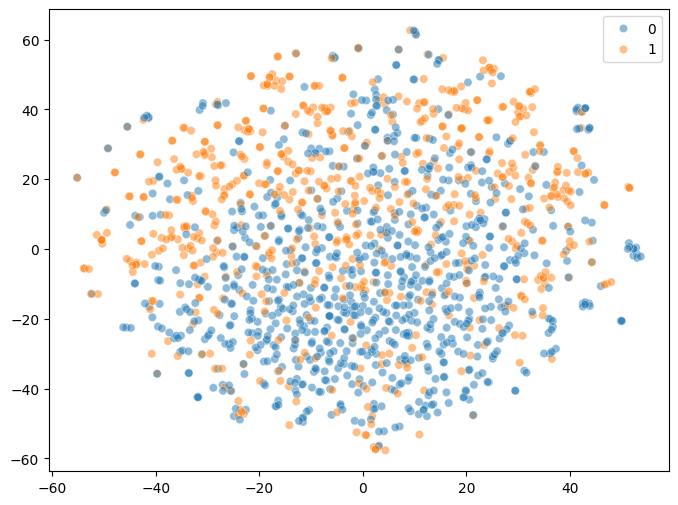

In [40]:
X_val_tsne = visualize_tsne(base_pipeline.named_steps['preproc'].transform(X_val).toarray(), y_val, n_components=2)

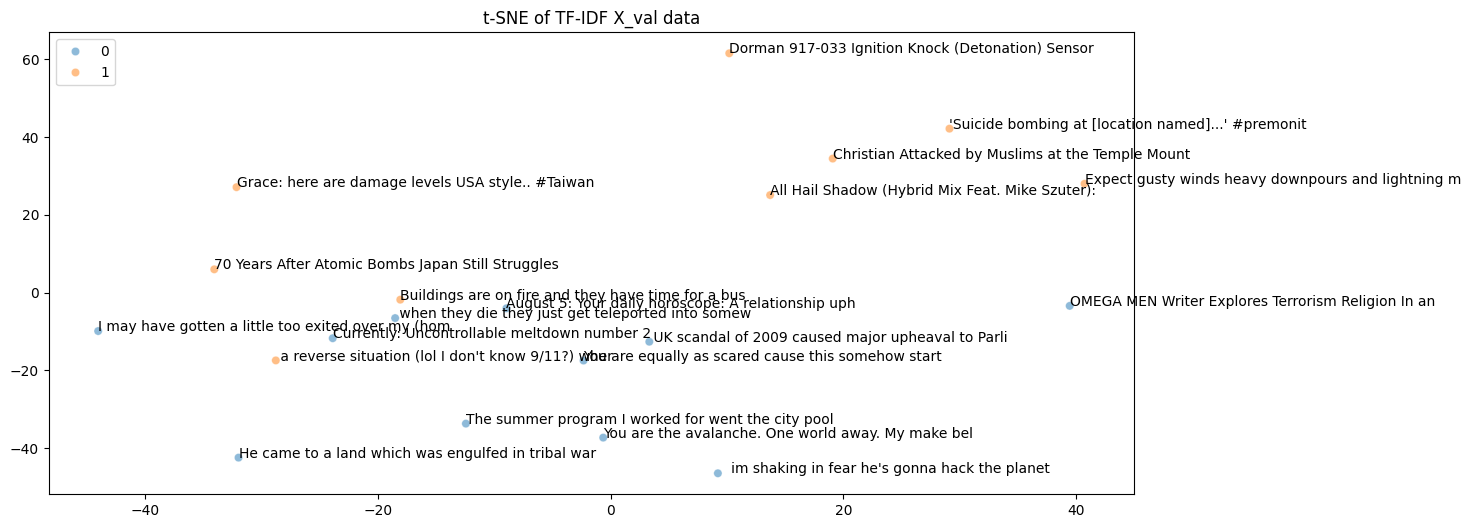

In [45]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=X_val_tsne[0:20, 0], y=X_val_tsne[0:20, 1], hue=y_val[0:20], alpha=0.5)

for i, txt in enumerate(X_val['text'].values[0:20]):
    plt.annotate(txt[0:50], (X_val_tsne[i, 0], X_val_tsne[i, 1]))

plt.title('t-SNE of TF-IDF X_val data')
plt.show()

### Naive Bayes

In [48]:
class ArrayTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [49]:
drop_cols = []
target = ['target']
X_train, y_train, X_val, y_val = get_train_val(data, drop_cols, target)

nb_preprocessor = ColumnTransformer(
    [('countvec', CountVectorizer(encoding='unicode'), 'text')])

nb_pipeline = Pipeline([
    ('preproc', nb_preprocessor),
    ('to_array', ArrayTransformer()),
    ('clf', GaussianNB()),
])

nb_pipeline.fit(X_train, y_train)

print('Train F1 score:', f1_score(y_train, nb_pipeline.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, nb_pipeline.predict(X_val)))

Train F1 score: 0.920344645683137
Validation F1 score: 0.6270337922403004


### Tuned Logistic Regression models

The logistic regression model will be tuned using the tf-idf vectorized features on the preprocessed text lemmatized using the NLTK library

In [52]:
drop_cols = []
target = ['target']

X_train, y_train, X_val, y_val = get_train_val(data, drop_cols, target)


preprocessor = ColumnTransformer(
    [('tfidf', TfidfVectorizer(encoding='unicode'), 'text_nltk')])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(random_state=0)),
])

parameters = {
    'preproc__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    #'preproc__tfidf__max_features': [1000, 3000, None],
    'preproc__tfidf__min_df': [0.0001, 0.001, 0.01, 1],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__class_weight': ['balanced', None],
}

nltk_search = GridSearchCV(pipeline, parameters, cv=3, verbose=1, scoring='f1')
nltk_search.fit(X_train, y_train)

print('Best score: %.3f' % nltk_search.best_score_)
print('Config: %s' % nltk_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best score: 0.748
Config: {'clf__C': 10.0, 'clf__class_weight': None, 'preproc__tfidf__min_df': 0.0001, 'preproc__tfidf__ngram_range': (1, 2)}


In [53]:
print('Train F1 score:', f1_score(y_train, nltk_search.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, nltk_search.predict(X_val)))

Train F1 score: 0.986159169550173
Validation F1 score: 0.7711598746081505


In [54]:
feat_importances(nltk_search.best_estimator_[0].get_feature_names_out(), nltk_search.best_estimator_[1].coef_[0], k=10)

|       | feature           |   feature_importance |   coef_value |
|------:|:------------------|---------------------:|-------------:|
| 30216 | tfidf__in         |              7.60952 |      7.60952 |
| 66806 | tfidf__you        |              6.54132 |     -6.54132 |
| 28667 | tfidf__hiroshima  |              6.44361 |      6.44361 |
| 10610 | tfidf__california |              5.92111 |      5.92111 |
| 39322 | tfidf__my         |              5.56525 |     -5.56525 |
| 60372 | tfidf__train      |              5.55415 |      5.55415 |
| 64987 | tfidf__wildfire   |              5.4221  |      5.4221  |
| 22981 | tfidf__fire       |              5.34975 |      5.34975 |
| 54317 | tfidf__storm      |              5.01744 |      5.01744 |
|  9009 | tfidf__bombing    |              4.89672 |      4.89672 |


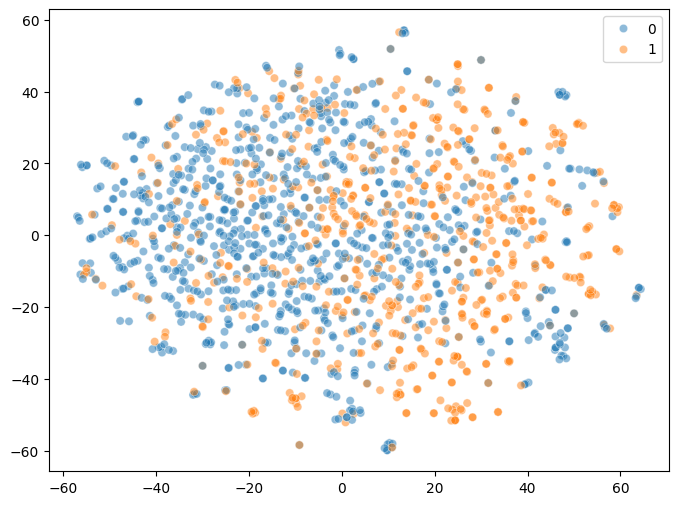

In [57]:
X_val_tsne = visualize_tsne(nltk_search.best_estimator_.named_steps['preproc'].transform(X_val).toarray(), y_val, n_components=2)

- Next, a model with the same parameters will be trained on text lemmatized with the spacy library

In [58]:
preprocessor = ColumnTransformer(
    [('tfidf', TfidfVectorizer(encoding='unicode'), 'text_spcy')])

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(random_state=0)),
])

parameters = {
    'preproc__tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    #'preproc__tfidf__max_features': [1000, 3000, None],
    'preproc__tfidf__min_df': [0.0001, 0.001, 0.01, 1],
    'preproc__tfidf__stop_words': [stop_words],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__class_weight': ['balanced', None],
}

spcy_search = GridSearchCV(pipeline, parameters, cv=3, verbose=1, scoring='f1')
spcy_search.fit(X_train, y_train)

print('Best score: %.3f' % spcy_search.best_score_)
print('Config: %s' % spcy_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best score: 0.742
Config: {'clf__C': 10.0, 'clf__class_weight': None, 'preproc__tfidf__min_df': 0.0001, 'preproc__tfidf__ngram_range': (1, 2), 'preproc__tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'm

In [60]:
print('Train F1 score:', f1_score(y_train, spcy_search.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, spcy_search.predict(X_val)))

Train F1 score: 0.9878916009994234
Validation F1 score: 0.7579908675799086


In [64]:
feat_importances(spcy_search.best_estimator_[0].get_feature_names_out(), spcy_search.best_estimator_[1].coef_[0], k=10)

|       | feature           |   feature_importance |   coef_value |
|------:|:------------------|---------------------:|-------------:|
| 20160 | tfidf__fire       |              7.20286 |      7.20286 |
| 24787 | tfidf__hiroshima  |              7.17159 |      7.17159 |
|  8062 | tfidf__california |              6.14137 |      6.14137 |
| 52732 | tfidf__wildfire   |              6.03116 |      6.03116 |
| 49001 | tfidf__train      |              5.77877 |      5.77877 |
|  6858 | tfidf__bombing    |              5.76334 |      5.76334 |
|  7560 | tfidf__building   |              5.49562 |      5.49562 |
| 28012 | tfidf__kill       |              5.11271 |      5.11271 |
| 31491 | tfidf__massacre   |              4.78923 |      4.78923 |
| 17264 | tfidf__earthquake |              4.72067 |      4.72067 |


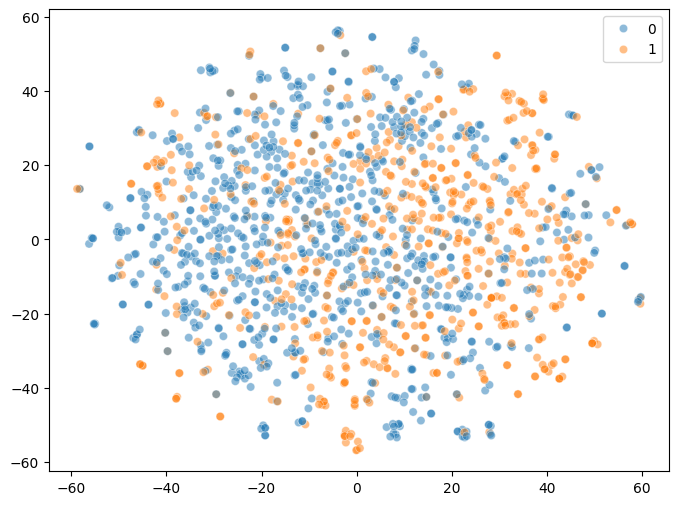

In [62]:
X_val_tsne = visualize_tsne(spcy_search.best_estimator_.named_steps['preproc'].transform(X_val).toarray(), y_val, n_components=2)

- As a next step, using TruncatedSVD over TF-IDF features in order to lower the dimensionality of the training data.

In [66]:
drop_cols = []
target = ['target']

X_train, y_train, X_val, y_val = get_train_val(data, drop_cols, target)

preprocessor = ColumnTransformer(
    [('tfidf', TfidfVectorizer(encoding='unicode'), 'text_spcy')]
    )

svd_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svd', TruncatedSVD(n_components=300, n_iter=5, random_state=0)),
    ('clf', LogisticRegression(random_state=0)),
])

svd_pipeline.fit(X_train, y_train)

print('Train F1 score:', f1_score(y_train, svd_pipeline.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, svd_pipeline.predict(X_val)))

Train F1 score: 0.7449392712550608
Validation F1 score: 0.7473073736536868


- In summary, the model that utilized the SVD transormation of the data shows similar to previous models performance and at the same time, it did not overfit training data as much as previous models.

In [ ]:
drop_cols = []
target = ['target']

X_train, y_train, X_val, y_val = get_train_val(data, drop_cols, target)

preprocessor = ColumnTransformer(
    [('tfidf', TfidfVectorizer(encoding='unicode'), 'text')])

base_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(random_state=0)),
])

base_pipeline.fit(X_train, y_train)

print('Train F1 score:', f1_score(y_train, base_pipeline.predict(X_train)))
print('Validation F1 score:', f1_score(y_val, base_pipeline.predict(X_val)))

### Word2Vec

The logistic regression model will be tuned using the Word2Vec model embeddings

In [80]:
w2vmodel = Word2Vec(vector_size=300, window=4, min_count=4, sg=1)

X_train, y_train, X_test = get_embeddings(w2vmodel, data, test_data, 'token_nltk', 'target')

X_tr, X_vl, y_tr, y_vl = train_test_split(X_train, y_train, test_size=0.2, random_state=0, shuffle=True, stratify=y_train)

In [81]:
pipeline = Pipeline([
    ('clf', LogisticRegression(random_state=0)),
])

parameters = {
    'clf__C': uniform(0.01, 10),
    'clf__class_weight': ['balanced'],
    'clf__max_iter': [300]
}

w2v_search = RandomizedSearchCV(pipeline, parameters, cv=3, n_iter=30, verbose=1, scoring='f1', random_state=0)
w2v_search.fit(X_tr, y_tr)

print('Best score: %.3f' % w2v_search.best_score_)
print('Config: %s' % w2v_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.684
Config: {'clf__C': 9.646627605010293, 'clf__class_weight': 'balanced', 'clf__max_iter': 300}


In [82]:
print('Train F1 score:', f1_score(y_tr, w2v_search.predict(X_tr)))
print('Validation F1 score:', f1_score(y_vl, w2v_search.predict(X_vl)))

Train F1 score: 0.6902554399243142
Validation F1 score: 0.7107692307692308


- Let's take a look at t-sne visualization of word2vec embeddings. Compared to similar visualization of the tf-idf encoded data it appears that embeddings are better at creating visible "gaps" between clouds of points of different classes even though the validation metric for the word2vec model is lower compared to the model based on tf-idf features.

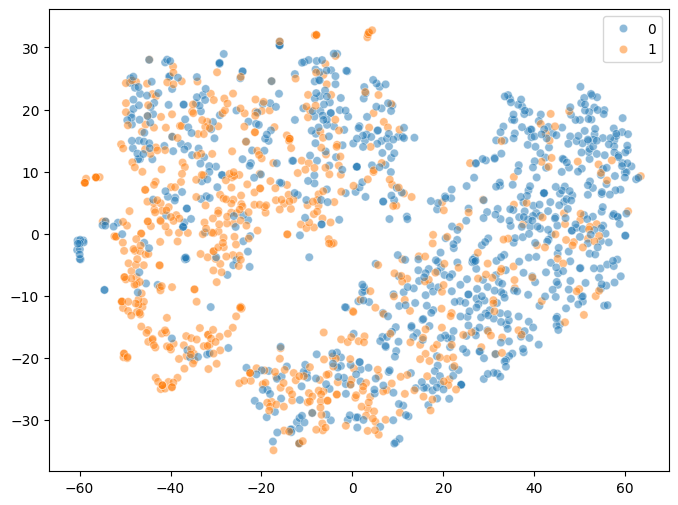

In [83]:
X_vl_tsne = visualize_tsne(X_vl, y_vl, n_components=2)

- The Logistic Regression classifier trained on Word2Vec embeddings performs worse than previous models based on tf-idf vectorized features.

- Let's sample some tweets from the training data and see which words are considered 'similar' to them according to the trained Word2Vec model

In [84]:
data['token_nltk'].sample(3).values

array([list(['haha', 'i', 'love', 'hurricane', 'because', 'of', 'you']),
       list(['tonight', 'is', 'being', 'quite', 'interesting', 'a', 'few', 'minute', 'ago', 'the', 'fire', 'system', 'went', 'off', 'and', 'we', 'had', 'to', 'evacuate', 'the', 'building']),
       list(['toronto', 'going', 'crazy', 'for', 'the', 'blue', 'jays', 'can', 'you', 'imagine', 'if', 'the', 'leaf', 'get', 'good', 'the', 'city', 'might', 'literally', 'explode'])],
      dtype=object)

In [86]:
words=["hurricane", "fire", "system", "evacuate", "city", "explode", "building"]

print('Top 3 words similar to')
for w in words:
    print(w, ':', list(zip(*w2vmodel.wv.most_similar(w, topn=3)))[0])

Top 3 words similar to
hurricane : ('drought', 'collide', 'album')
fire : ('rubble', 'fires', 'forest')
system : ('mountain', 'guard', 'quote')
evacuate : ('hellfire', 'answer', 'turn')
city : ('ash', 'total', 'month')
explode : ('believe', 'obliterated', 'destroy')
building : ('buildings', 'burning', 'run')


### FastText

In [87]:
ftmodel = FastText(vector_size=300, window=4, min_count=4, sg=1)

X_train, y_train, X_test = get_embeddings(ftmodel, data, test_data, 'token_nltk', 'target')

X_tr, X_vl, y_tr, y_vl = train_test_split(X_train, y_train, test_size=0.2, random_state=0, shuffle=True, stratify=y_train)

In [88]:
words=["weather", "storm", "people", "emergency", "city", "weapon", "security"]

print('Top 3 words similar to')
for w in words:
    print(w, ':', list(zip(*ftmodel.wv.most_similar(w, topn=3)))[0])

Top 3 words similar to
weather : ('leather', 'further', 'chinese')
storm : ('windstorm', 'sandstorm', 'rainstorm')
people : ('whats', 'thats', 'th')
emergency : ('enugu', 'kiernan', 'forces')
city : ('alaska', 'patience', 'galactic')
weapon : ('money', 'sometimes', 'toilet')
security : ('australian', 'syria', 'pakistani')


In [89]:
pipeline = Pipeline([
    ('clf', LogisticRegression(random_state=0)),
])

parameters = {
    'clf__C': uniform(0.01, 10),
    'clf__class_weight': ['balanced'],
    'clf__max_iter': [300]
}

ft_search = RandomizedSearchCV(pipeline, parameters, cv=3, n_iter=30, verbose=1, scoring='f1', random_state=0)
ft_search.fit(X_tr, y_tr)

print('Best score: %.3f' % ft_search.best_score_)
print('Config: %s' % ft_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best score: 0.678
Config: {'clf__C': 9.79618342232764, 'clf__class_weight': 'balanced', 'clf__max_iter': 300}


In [90]:
print('Train F1 score:', f1_score(y_tr, ft_search.predict(X_tr)))
print('Validation F1 score:', f1_score(y_vl, ft_search.predict(X_vl)))

Train F1 score: 0.6769734448890505
Validation F1 score: 0.6740250183958794


- Let's also take a look at the fast text embeddings t-sne visualization

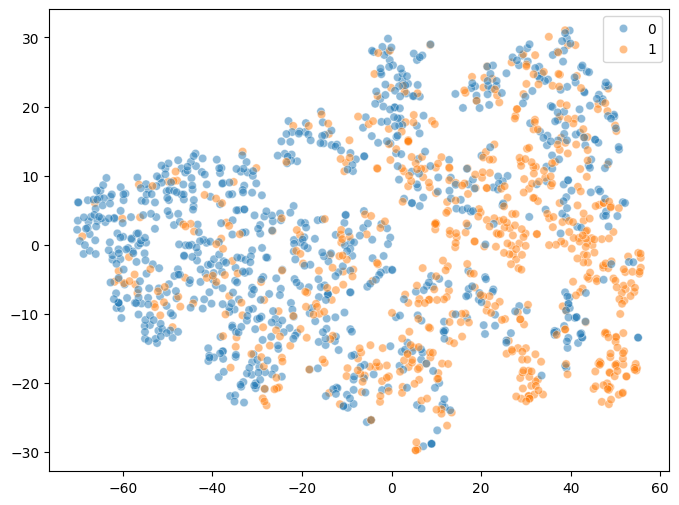

In [91]:
X_vl_tsne = visualize_tsne(X_vl, y_vl, n_components=2)